In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot

                  High         Low        Open       Close   Volume  \
Date                                                                  
2019-03-27  275.369995  268.179993  268.750000  274.829987  8779200   
2019-03-28  280.329987  275.100006  277.160004  278.619995  6774100   
2019-03-29  280.160004  274.500000  278.700012  279.859985  5991300   
2019-04-01  289.200012  281.279999  282.619995  289.179993  8110400   
2019-04-02  289.440002  283.880005  288.299988  285.880005  5478900   

             Adj Close      Gain      ema_12      ema_26      sma_20  \
Date                                                                   
2019-03-27  274.829987  7.059998  273.837117  282.881904  279.714998   
2019-03-28  278.619995  3.790009  274.572945  282.566207  277.651997   
2019-03-29  279.859985  1.239990  275.386336  282.365746  276.905496   
2019-04-01  289.179993  9.320007  277.508437  282.870505  277.096497   
2019-04-02  285.880005 -3.299988  278.796370  283.093431  277.563496  

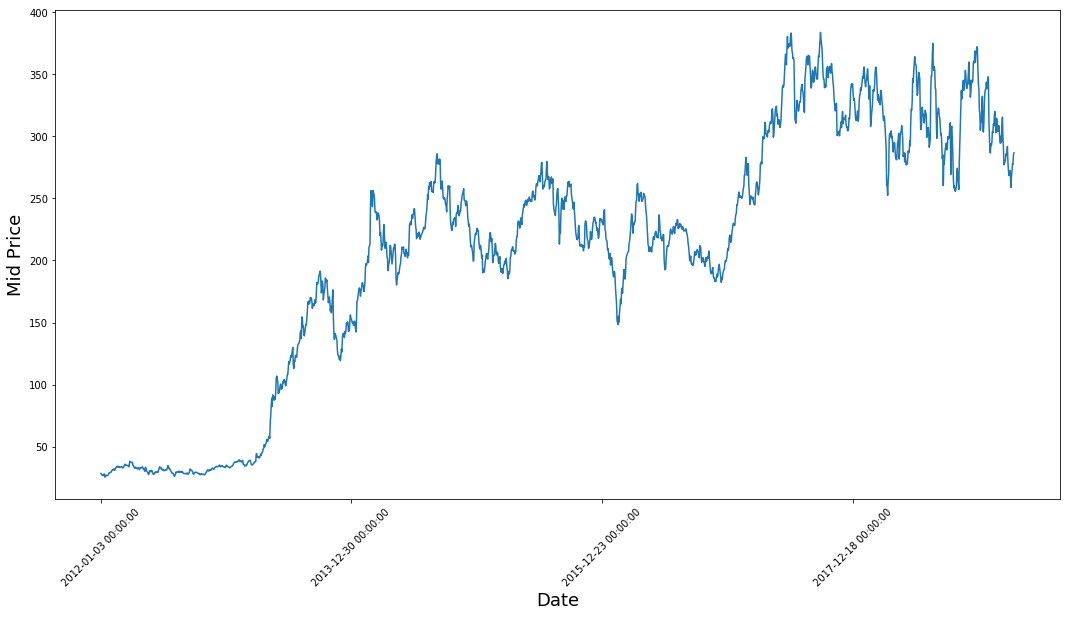

In [14]:
print(dataset.tail())
plt.figure(figsize = (18,9))
plt.plot(range(dataset.shape[0]),(dataset['Low']+dataset['High'])/2.0)
plt.xticks(range(0,dataset.shape[0],500),dataset.loc[::500].index,rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [ ]:
 # First calculate the mid prices from the highest and lowest
high_prices = dataset.loc[:,'High'].as_matrix()
low_prices = dataset.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0
print(len(high_prices))
train_data = mid_prices[:4000]
test_data = mid_prices[4000:]

In [ ]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [ ]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 200
for di in range(0,3800,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])


# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [ ]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [47]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(4000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [58]:
window_size = 60
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = dataset.index[pred_idx]

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.01462


<Figure size 1296x648 with 0 Axes>

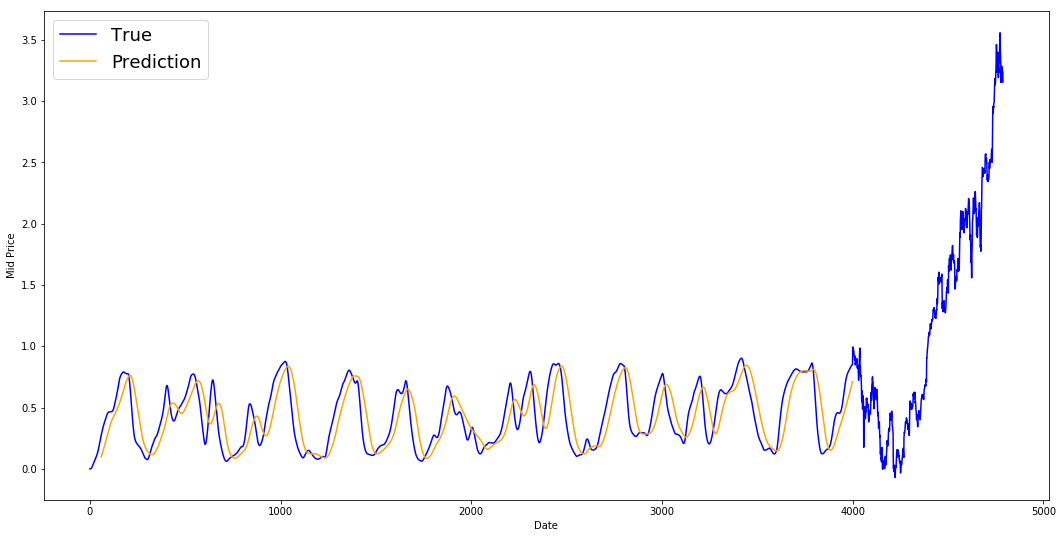

In [60]:
plt.figure(figsize = (18,9))
plt.plot(range(dataset.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [64]:
#Daily Prediction using EMA 
window_size = 60
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00011


<Figure size 1296x648 with 0 Axes>

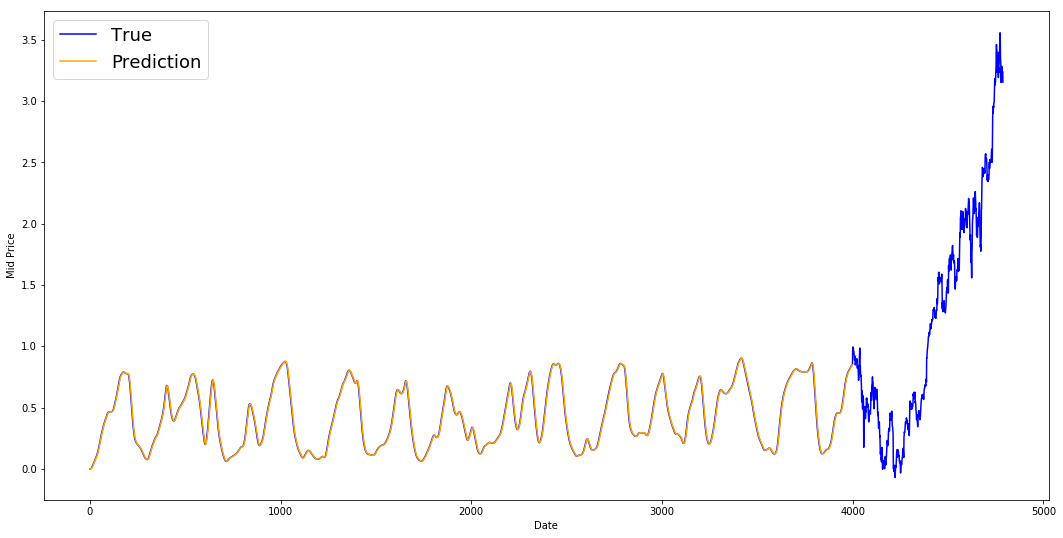

In [67]:
plt.figure(figsize = (18,9))
plt.plot(range(dataset.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()